In [25]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from qdots_qll.models.game import get_SIC_POVM_4D
import numpy as np

import qutip as qt

from jax.scipy.linalg import expm
from jax import jit

In [10]:
from qbism import sic_povm

In [11]:
def dag(A):
    return jnp.conjugate(A.T)


def sprepost(A, B):
    return jnp.kron(A, jnp.conjugate(B))


def spre(A):
    return sprepost(A, jnp.identity(2))


def spost(A):
    return sprepost(jnp.identity(2), A)


# def vec(A):
#     return A.flatten()
def vec(A):
    return A.flatten()
    # return A.flatten()[:, jnp.newaxis]

In [12]:
d = 2

In [13]:
povm_arr = jnp.array(sic_povm(d)) * d

In [14]:
?sic_povm

Signature: sic_povm(d)
Docstring: Returns a SIC-POVM of dimension $d$.
File:      ~/miniconda3/envs/jax/lib/python3.11/site-packages/qbism/sics.py
Type:      function

In [15]:
rng = np.random.default_rng(seed=1)

In [16]:
A = rng.random([2, 2]) + 1j * rng.random([2, 2])
B = rng.random([2, 2]) + 1j * rng.random([2, 2])
C = rng.random([2, 2]) + 1j * rng.random([2, 2])

In [17]:
vec(A @ B @ dag(C))

Array([1.1492252-0.04091862j, 1.6888942+0.01579123j,
       0.9675945+0.25725535j, 1.3005437+0.55467325j], dtype=complex64)

In [18]:
jnp.kron(A, jnp.conjugate(C)) @ vec(B)

Array([1.1492252-0.04091859j, 1.6888943+0.01579124j,
       0.9675946+0.25725538j, 1.3005437+0.5546732j ], dtype=complex64)

In [19]:
# def vec(A):
#     return A.flatten()[:, np.newaxis]

In [20]:
rho = qt.rand_dm(2, seed=1).full()

In [21]:
K = (d + 1) * jnp.array([vec(pi) for pi in list(povm_arr)]).T - jnp.array(
    [vec(jnp.identity(2))] * d**2
).T

In [22]:
K_inv = (jnp.array([dag(vec(pi)) for pi in list(povm_arr)])) / d

In [26]:
@jit
def _make_C(H, V):
    return H - 1j / 2 * dag(V) @ V


@jit
def _make_Lambda(H, V):
    return (
        -1j * (spre(H) - spost(H))
        + sprepost(V, dag(V))
        - 0.5 * (spre(dag(V) @ V) + spost(dag(V) @ V))
    )


@jit
def make_L(K, K_inv, H, V):
    return K_inv @ _make_Lambda(H, V) @ K

In [58]:
# V = jnp.sqrt(0.1) * qt.sigmap().full() * 1
V = jnp.sqrt(0.1) * qt.sigmam().full() * 1

In [59]:
rho0 = qt.ket2dm(qt.basis(2, 0)).full()

In [60]:
omega = 0.5

H = omega / 2 * qt.sigmax().full()

In [61]:
L = make_L(K, K_inv, H, V)

In [62]:
my_povm = jnp.array(
    (qt.identity(2).full() + jnp.array([qt.sigmaz(), -qt.sigmaz()])) / 2
)

In [63]:
m = jnp.einsum("iljj", jnp.einsum("ijk, lkn ->iljn", my_povm, povm_arr))


E = jnp.einsum("i, m -> im", jnp.einsum("ijj", my_povm), jnp.ones(d**2))

M = (d + 1) * m - E

In [64]:
def rho_to_psic(rho, povm_arr, d):
    return jnp.einsum("ill", jnp.einsum("ijk, kl -> ijl", povm_arr, rho)) / d

In [65]:
def psic_to_rho(p_arr, povm_arr, d):
    K = (d + 1) * povm_arr - jnp.identity(2)
    return jnp.einsum("ijk,i", K, p_arr)

In [66]:
P_0 = rho_to_psic(qt.ket2dm(qt.basis(2, 0)).full(), povm_arr, d)

In [67]:
L = make_L(K, K_inv, H, V)

In [68]:
times = jnp.linspace(0, 100, 1000)

In [69]:
P_times = jax.vmap(lambda t: expm(L * t) @ P_0)(times)

/home/antonio/miniconda3/envs/jax/lib/python3.11/site-packages/jax/_src/array.py:377: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(self._value, dtype=dtype)


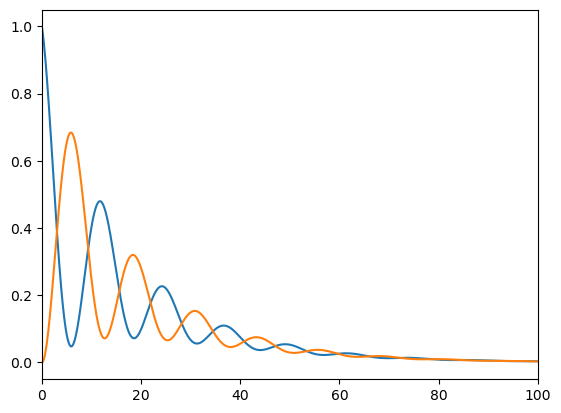

In [70]:
plt.plot(times, jax.vmap(lambda psic: M @ psic)(P_times).T[0])
plt.plot(times, jax.vmap(lambda psic: M @ psic)(P_times).T[1])
plt.xlim(0, 100)
plt.show()

In [72]:
import equinox as eqx

In [891]:
@jit
def sprepost(A, B):
    return jnp.kron(A, jnp.transpose(B))


def make_K(d, povm_arr):
    K = (d + 1) * jnp.array([vec(pi) for pi in list(povm_arr)]).T - jnp.array(
        [vec(jnp.identity(d))] * d**2
    ).T
    return K


def make_K_inv(d, povm_arr):
    return (jnp.array([dag(vec(pi)) for pi in list(povm_arr)])) / d


dimensions_list = [2, 3, 4, 5, 6, 7]
dimensions_list_str = [str(i) for i in dimensions_list]


list_sic_povm_arr = list(
    [(lambda d: jnp.array(sic_povm(d)) * d)(d) for d in dimensions_list]
)

list_K_mat = []
list_K_inv_mat = []
for i in zip(dimensions_list, list_sic_povm_arr):
    list_K_mat.append(make_K(*i))
    list_K_inv_mat.append(make_K_inv(*i))

sic_povm_dictionary = dict(
    map(lambda i, j: (i, j), dimensions_list_str, list_sic_povm_arr)
)

K_mat_dictionary = dict(
    map(lambda i, j: (i, j), dimensions_list_str, list_K_mat)
)

K_inv_mat_dictionary = dict(
    map(lambda i, j: (i, j), dimensions_list_str, list_K_inv_mat)
)

In [892]:
class sic_povm_model(eqx.Module):
    d: int
    md: jnp.array
    sic_povm_arr: jnp.array
    K_mat: jnp.array
    K_inv_mat: jnp.array

    def __init__(self, d):
        self.d = d
        self.md = jnp.ones([d, d])
        self.sic_povm_arr = sic_povm_dictionary[str(d)]
        self.K_mat = K_mat_dictionary[str(d)]
        self.K_inv_mat = K_inv_mat_dictionary[str(d)]

    @jit
    def example_f(self):
        return jnp.identity(d)

    @jit
    def spre(self, A):
        return sprepost(A, jnp.identity(self.md.shape[0]))

    @jit
    def spost(self, A):
        return sprepost(jnp.identity(self.md.shape[0]), A)

In [894]:
almostzero = 1e-8


class my_model(sic_povm_model):
    number_of_parameters: int
    omega: float
    gamma: float
    rho_0: jnp.array
    P_0: jnp.array
    measurement_POVM: jnp.array
    M: jnp.array

    def __init__(self, d, rho_0, measurement_POVM):
        super().__init__(d)
        self.number_of_parameters = 2
        self.omega = 0.5
        self.gamma = 0.1
        self.rho_0 = rho_0
        self.P_0 = self.rho_to_psic(rho_0)
        self.measurement_POVM = measurement_POVM
        self.M = self.M_sic_to_mypovm(self.measurement_POVM)

    @jit
    def make_H0(self):
        return jnp.array([[0, 1], [1, 0]])

    @jit
    def make_dissipator(self):
        V = jnp.array([[1, 0], [0, 0]])
        return sprepost(V, dag(V)) - 0.5 * (
            spre(dag(V) @ V) + spost(dag(V) @ V)
        )

    @jit
    def M_sic_to_mypovm(self, my_povm):
        d = self.md.shape[0]
        m = jnp.einsum(
            "iljj", jnp.einsum("ijk, lkn ->iljn", my_povm, self.sic_povm_arr)
        )
        E = jnp.einsum(
            "i, m -> im", jnp.einsum("ijj", my_povm), jnp.ones(d**2)
        )
        M = (d + 1) * m - E
        return M

    @jit
    def rho_to_psic(self, rho):
        d = self.md.shape[0]
        povm_arr = self.sic_povm_arr
        return (
            jnp.einsum("ill", jnp.einsum("ijk, kl -> ijl", povm_arr, rho)) / d
        )

    @jit
    def sic_to_povm(self, sicP):
        M = self.M
        return M @ sicP

    @jit
    def psic_to_rho(self, p_array):
        d = self.md.shape[0]
        povm_arr = self.sic_povm_arr
        K = (d + 1) * povm_arr - jnp.identity(2)
        return jnp.einsum("ijk,i", K, p_array)

    @jit
    def make_L(self, particle):
        omega = particle[0]
        gamma = particle[1]
        H = omega * self.make_H0()
        D = gamma * self.make_dissipator()
        return -1j * (spre(H) - spost(H)) + D

    @jit
    def make_LP(self, particle):
        L = self.make_L(particle)

        return self.K_inv_mat @ L @ self.K_mat

    # TODO Make the function that computes P safe.
    @jit
    def likelihood_sic_particle(self, particle, t):
        L = self.make_LP(particle)
        return jnp.real(expm(L * t) @ self.P_0)

    @jit
    def likelihood_povm_particle(self, particle, t):
        evolved_Psic = self.likelihood_sic_particle(particle, t)

        return jnp.real(self.sic_to_povm(evolved_Psic))

    @jit
    def fim_sic(self, particle, t):
        """Given a particle and time, computes the Fisher Information Matrix

        Args:
            particle (_type_): (j)np array of particle
            t (_type_): time

        Returns:
            _type_: _description_
        """
        jacobian = jnp.array(
            jax.jacobian(self.likelihood_sic_particle, 0)(particle, t)
        ).T
        lkl = jnp.array(self.likelihood_sic_particle(particle, t))
        return jnp.einsum("ij, ik, i -> jk", jacobian, jacobian, 1 / lkl)

    @jit
    def fim_povm(self, particle, t):
        jacobian = jnp.array(
            jax.jacobian(self.likelihood_povm_particle, 0)(particle, t)
        ).T
        lkl = jnp.array(self.likelihood_povm_particle(particle, t))
        return jnp.einsum("ij, ik, i -> jk", jacobian, jacobian, 1 / lkl)

    # @jit
    # def log_likelihood_matrix_sic(self, particle, t ):

    # @jit
    # def log_lik
    # # @jit
    # def log_lkl_sic_particle(self, particle, t):
    #     L = self.make_LP(particle)
    #     return (L * t) + jnp.log(  self.P_0)

In [895]:
my_povm

Array([[[1.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j]],

       [[0.+0.j, 0.+0.j],
        [0.+0.j, 1.+0.j]]], dtype=complex64)

In [896]:
x_povm = (
    qt.identity(2).full()
    + jnp.array([qt.sigmax().full(), -qt.sigmax().full()])
) / 2

z_povm = (
    qt.identity(2).full()
    + jnp.array([qt.sigmaz().full(), -qt.sigmaz().full()])
) / 2

y_povm = (
    qt.identity(2).full()
    + jnp.array([qt.sigmay().full(), -qt.sigmay().full()])
) / 2

In [897]:
((np.concatenate([x_povm, z_povm, y_povm])) / 3).sum(0)

array([[1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j]], dtype=complex64)

In [898]:
(qt.identity(2).full() + np.array([1, -1]) * (qt.sigmaz().full())) / 2

array([[1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j]])

In [899]:
model = my_model(2, rho0, (np.concatenate([x_povm, z_povm, y_povm])) / 3)

In [900]:
model.measurement_POVM

array([[[ 0.16666667+0.j        ,  0.16666667+0.j        ],
        [ 0.16666667+0.j        ,  0.16666667+0.j        ]],

       [[ 0.16666667+0.j        , -0.16666667+0.j        ],
        [-0.16666667+0.j        ,  0.16666667+0.j        ]],

       [[ 0.33333334+0.j        ,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.        +0.j        ]],

       [[ 0.        +0.j        ,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.33333334+0.j        ]],

       [[ 0.16666667+0.j        ,  0.        -0.16666667j],
        [ 0.        +0.16666667j,  0.16666667+0.j        ]],

       [[ 0.16666667+0.j        ,  0.        +0.16666667j],
        [ 0.        -0.16666667j,  0.16666667+0.j        ]]],
      dtype=complex64)

In [901]:
times = jnp.linspace(0, 150, 2000)

/home/antonio/miniconda3/envs/jax/lib/python3.11/site-packages/jax/_src/lax/lax.py:2652: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


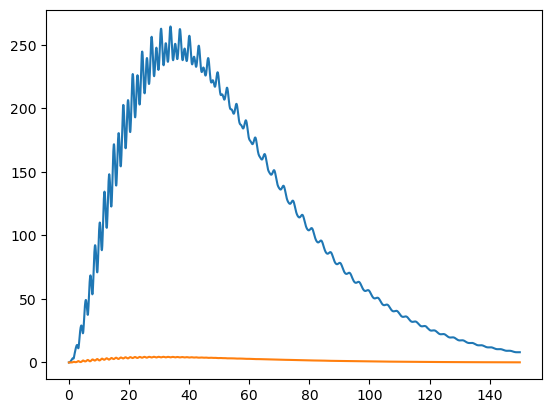

In [902]:
fim_times = jnp.real(
    jax.vmap(lambda t: model.fim_povm([model.omega, 1.1 * model.gamma], t))(
        times
    )
)

for i in range(2):
    plt.plot(
        times,
        fim_times[:, i, i],
    )

# plt.plot(times, fim_times[:, 1, 1])
plt.show()

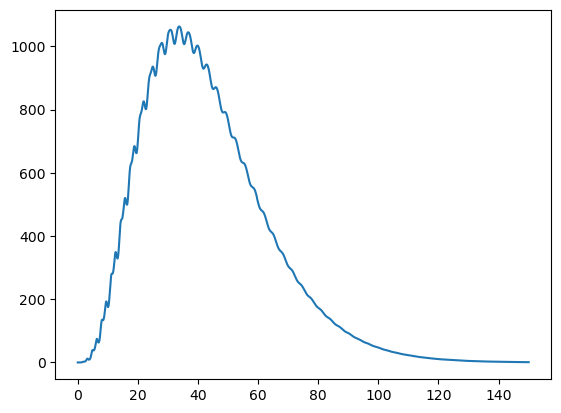

In [903]:
fim_times = jnp.real(
    jax.vmap(
        lambda t: jnp.linalg.det(
            model.fim_povm([model.omega, 1.1 * model.gamma], t)
        )
    )(times)
)

# for i in range(2):
#     plt.plot(
#         times,
#         fim_times[:, i, i],
#     )

plt.plot(times, fim_times)
plt.show()

In [904]:
model.P_0

Array([0.39433756+0.j, 0.39433756+0.j, 0.10566244+0.j, 0.10566244+0.j],      dtype=complex64)

In [388]:
jnp.log(model.P_0) + jax.scipy.linalg.logm(model.make_LP(par) * ti)

AttributeError: module 'jax.scipy.linalg' has no attribute 'logm'

In [431]:
lambdas, U = jnp.linalg.eigh((model.make_LP(par) * ti).round(6))

In [432]:
(model.make_LP(par) * ti).round(6)

Array([[-0.206353 -0.j,  3.958229 +0.j, -0.       -0.j, -3.7518759+0.j],
       [-3.545523 +0.j, -0.206353 -0.j,  3.7518759+0.j,  0.       -0.j],
       [-0.       +0.j, -3.7518759-0.j, -0.206353 +0.j,  3.958229 -0.j],
       [ 3.7518759-0.j, -0.       +0.j, -3.545523 -0.j, -0.206353 +0.j]],      dtype=complex64)

In [434]:
U.T @ jnp.diag(lambdas) @ jnp.linalg.inv(U.T)

Array([[-4.1270608e-01+0.j,  0.0000000e+00+0.j,  2.3226232e-08+0.j,
         0.0000000e+00+0.j],
       [ 0.0000000e+00+0.j,  6.5537520e-08+0.j,  0.0000000e+00+0.j,
        -1.9495734e-15+0.j],
       [-6.5760908e-09+0.j,  0.0000000e+00+0.j, -4.1270605e-01+0.j,
         0.0000000e+00+0.j],
       [ 0.0000000e+00+0.j,  1.6031403e-15+0.j,  0.0000000e+00+0.j,
         6.5537513e-08+0.j]], dtype=complex64)

In [418]:
jnp.isclose(
    U.round(5) @ jnp.diag(lambdas) @ dag(U).round(5),
    (model.make_LP(par) * ti).round(5),
)

Array([[False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False]], dtype=bool)

In [385]:
jnp.log(model.likelihood_sic_particle(par, ti))

Array([-0.9066924, -1.6960286, -2.3419278, -1.1501496], dtype=float32)

In [435]:
qt.sigmaz() * qt.sigmay()

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0.+0.j 0.-1.j]
 [0.-1.j 0.+0.j]]

In [441]:
1j * qt.sigmay()

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 0.  1.]
 [-1.  0.]]

In [439]:
qt.sigmap()

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0. 1.]
 [0. 0.]]

In [438]:
qt.sigmax()

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0. 1.]
 [1. 0.]]

In [436]:
qt.sigmay() * qt.sigmaz()

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0.+0.j 0.+1.j]
 [0.+1.j 0.+0.j]]

In [444]:
# Checking vectorization things

A
B
C

array([[0.1340417 +0.75036467j, 0.40311299+0.28040876j],
       [0.20345524+0.48519097j, 0.26231334+0.9807372j ]])

In [450]:
dag(vec(dag(A))) @ vec(B)

Array(0.44263655+1.7341907j, dtype=complex64)

In [448]:
jnp.trace(A @ B)

Array(0.44263652+1.7341907j, dtype=complex64)

# Computation of qfim for an example L

In [905]:
omega = 0.5

H = omega / 2 * qt.sigmax() + 0.25 / 2 * qt.sigmaz()

In [906]:
vec(rho0)

array([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j])

In [907]:
def _make_dissipator(V):
    return +sprepost(V, dag(V)) - 0.5 * (spre(dag(V) @ V) + spost(dag(V) @ V))

In [908]:
def unvec(Avec, d):
    return Avec.reshape(d, d)

In [910]:
L = _make_Lambda(jnp.array(H), 0.2 * jnp.array(qt.sigmaz()))

Dsuperop = _make_dissipator(0.2 * jnp.array(qt.sigmaz()))

times = jnp.linspace(0, 100, 1000)

rhot_v = jax.vmap(lambda t: (expm(L * t) @ vec(rho0)))(times)
rhot = jax.vmap(lambda a: unvec(a, 2))(rhot_v)

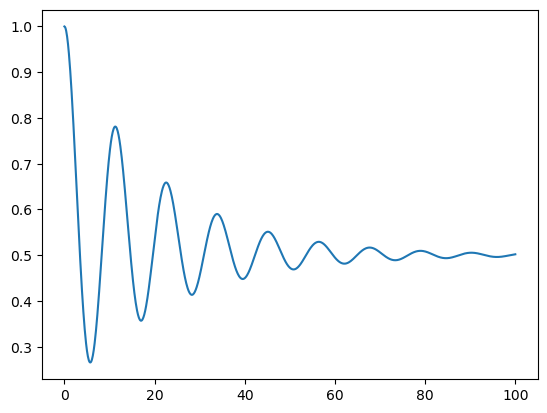

In [911]:
plt.plot(times, jnp.real(rhot[:, 0, 0]))

In [525]:
Dsuperop @ rhot_v[300]

Array([-0.00874202-1.9853836e-09j, -0.0024625 +2.7418875e-03j,
        0.00246251-9.1121625e-03j,  0.        +0.0000000e+00j],      dtype=complex64)

In [527]:
jnp.kron(eigvecs[0], eigvecs[1])

Array([-0.3051004 -0.39463377j,  0.32681364+0.42271882j,
       -0.2848298 -0.36841467j,  0.3051004 +0.39463377j], dtype=complex64)

In [529]:
vec(jnp.kron(eigvecs[0], eigvecs[1]))

Array([-0.3051004 -0.39463377j,  0.32681364+0.42271882j,
       -0.2848298 -0.36841467j,  0.3051004 +0.39463377j], dtype=complex64)

In [531]:
jnp.dot(dag(vec(jnp.kron(eigvecs[0], eigvecs[1]))), Dsuperop @ rhot_v[300])

Array(0.00567712+0.00198978j, dtype=complex64)

In [666]:
valaux = jnp.trace(
    dag(jnp.outer(eigvecs[0], eigvecs[1])) @ unvec(Dsuperop @ rhot_v[300], 2)
)
valaux

Array(0.00567712+0.00198978j, dtype=complex64)

In [ ]:
# First we need to evolve the matrix. Easy
# Then we diagonalize jnp.linalg.eig(unvec(evolved_matrix_vec))
# Check eigenvalues that are different from zero (how to do this with jax)
# For those eigenvalues, compute the projectors.
# And then compute the inner product and that shit.

In [550]:
# list with eigenvalues, [1, 2, 3, 4], we need to check which pairs sum != 0.as_integer_ratio

In [703]:
from itertools import  product

In [912]:
@jit
def generate_index_pairs_list_ev(list_indexes):
    return jnp.array(list(product(list(list_indexes), list(list_indexes))))


@jit
def check_valid_combinations(list_ev, array_index_pairs):
    which_combination_append = jax.vmap(
        lambda pair: jax.lax.cond(
            (lambda x: jnp.isclose(list_ev[x[0]] + list_ev[x[1]], 0))(pair),
            lambda pair: False,
            lambda pair: True,
            pair,
        )
    )(array_index_pairs)
    return which_combination_append


@jit
def compute_qfim_element_pair(
    pair, eigvecs_array, eigvals_array, rhot_v, Dsuperop
):
    i1, i2 = list(pair)
    superket = Dsuperop @ rhot_v
    superbra = dag(vec(jnp.kron(eigvecs_array[i1], eigvecs_array[i2])))

    aux_val = jnp.dot(superbra, superket)
    return (
        jnp.absolute(aux_val) ** 2
        * eigvals_array[i1]
        / (eigvals_array[i1] + eigvals_array[i2]) ** 2
    )


@jit
def qfim_element_pair_condition(
    condition, pair, eigvecs_array, eigvals_array, rhot_v, Dsuperop
):
    return jax.lax.cond(
        condition,
        lambda value: compute_qfim_element_pair(*value),
        lambda value: 0.0,
        [pair, eigvecs_array, eigvals_array, rhot_v, Dsuperop],
    )


@jit
def compute_qfim(rho_mat, Dsuperop, t):
    # rho_mat = unvec(rho_vec, d)
    rho_vec = vec(rho_mat)
    eigvals, eigvecs = jnp.linalg.eigh(rho_mat)

    ev_indexes_array = jnp.arange(eigvals.shape[0])

    index_pairs = generate_index_pairs_list_ev(ev_indexes_array)

    valid_pairs = check_valid_combinations(eigvals, index_pairs)

    return (
        jnp.sum(
            jax.vmap(
                lambda cond, index_pair: qfim_element_pair_condition(
                    cond, index_pair, eigvecs, eigvals, rho_vec, Dsuperop
                ),
                in_axes=(0, 0),
            )(valid_pairs, index_pairs)
        )
        * 4
        * t**2
    )

In [922]:
rho0 = qt.ket2dm((1 * qt.basis(2, 0) + 0 * qt.basis(2, 1)).unit()).full()

omega = 0.2

H = omega / 2 * qt.sigmax() + 0.25 / 2 * qt.sigmaz()

dissipator = 1 * _make_dissipator(0.1 * jnp.array(qt.sigmam()))


L = _make_Lambda(jnp.array(H), 0 * jnp.array(qt.sigmap())) + dissipator

# Dsuperop = _make_dissipator(0.1 * jnp.array(qt.sigmaz()))

times = jnp.linspace(0, 500, 1000)

rhot_v = jax.vmap(lambda t: jnp.einsum("ij, j -> i", expm(L * t), vec(rho0)))(
    times
)
rhot = jax.vmap(lambda a: unvec(a, 2))(rhot_v)

In [923]:
vec(rho0)

array([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j])

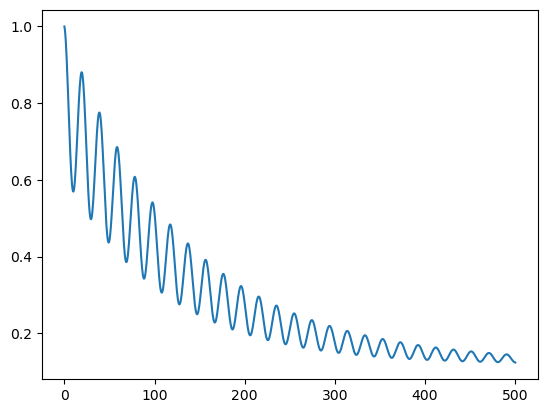

In [924]:
plt.plot(times, jnp.real(rhot[:, 0, 0]))

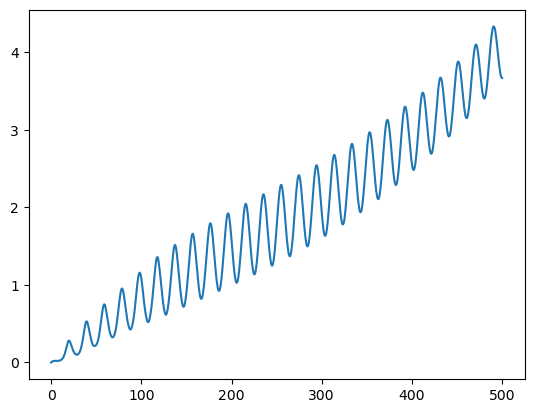

In [925]:
plt.plot(
    times,
    jax.vmap(lambda a, t: compute_qfim(unvec(a, 2), dissipator, t))(
        rhot_v, times
    ),
)

In [926]:
eigenvals = (jax.vmap(lambda rho: jnp.linalg.eigh(rho)[0])(rhot))

In [927]:
jnp.linalg.det(rhot[0])

Array(0.+0.j, dtype=complex64)

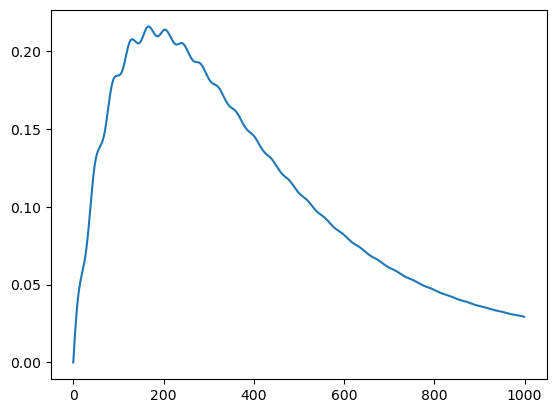

In [928]:
plt.plot(jnp.real(jax.vmap(lambda rho: jnp.linalg.det(rho))(rhot)))

In [929]:
times[jnp.argmin(eigenvals)]

Array(0., dtype=float32)

In [930]:
eigenvals[jnp.argmin(eigenvals)]

Array([0., 1.], dtype=float32)